In [ ]:
#| default_exp dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import ask_gpt4v
from llmcam.yolo import detect_objects
from llmcam.fn_to_fc import *
import json
import torch

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    path = f"../data/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '63593', 'Connection': 'keep-alive', 'x-amz-id-2': 'Di/coIBHuixmidMTeiEHMVQVgkkwCWvm3lkJvqVq44YUOW/s77lmNfcQH1EyQ7p3OD46N3IZ5qg=', 'x-amz-request-id': 'FM714FQNNT6XZAJE', 'last-modified': 'Wed, 13 Nov 2024 16:51:59 GMT', 'x-amz-expiration': 'expiry-date="Fri, 15 Nov 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Wed, 13 Nov 2024 16:51:59 GMT', 'x-amz-version-id': '0YCo0nTUNOo0sqTfyHkPX6EW8jXDecLH', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Wed, 13 Nov 2024 16:59:52 GMT', 'ETag': '"9ca74d636f755598d59e3020905dd349"', 'Vary': 'Accept-Encoding', 'X-Cache': 'RefreshHit from cloudfront', 'Via': '1.1 6a3ecfb1a4acff795e79a73839fdf21a.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': 'ycoPmhRXFM0GBnDVWrZQCz9SFvmpXINla6w5P_r73gVHVP_HFtxrFA=='}

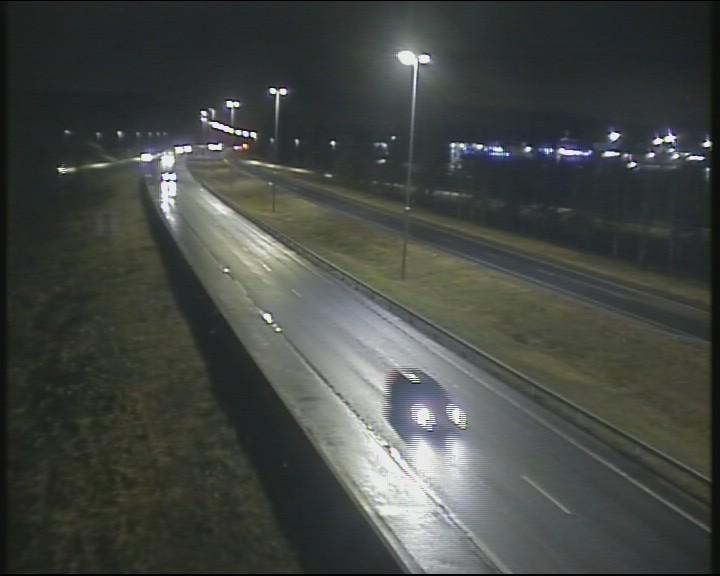

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str = "Porvoo", # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations(key)[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L46){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str)

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| key | str | location keyword |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
path = cap("porvoo")
print(path)
ask_gpt4v(path)

../data/cap_2024.11.13_16:51:59_Porvoo_C0150200.jpg


{'dimensions': {'width': 720, 'height': 576},
 'vehicles': {'number_of_vehicles': 5},
 'street_lights': {'number_of_street_lights': 10},
 'lighting': {'time_of_day': 'night', 'artificial_lighting': 1},
 'visibility': {'clear': True}}

In [ ]:
#| eval: false
detect_objects(cap('porvoo'))

Using cache found in /home/doyu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-12 Python-3.12.4 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/doyu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


{'car': 3, 'traffic light': 2, 'bus': 1}


'{\n  "car": 3,\n  "traffic light": 2,\n  "bus": 1\n}'

In [ ]:
#| eval: false
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return json.dumps(ask_gpt4v(path))

In [ ]:
#| eval: false
show_doc(__ask_gpt4v)

---

### __ask_gpt4v

>      __ask_gpt4v (path:str)

*ask gpt4v to analyze an image given*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | file path to analyze |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [cap, detect_objects, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'key': {'type': 'string',
      'description': 'location keyword'}},
    'required': ['key']}}},
 {'type': 'function',
  'function': {'name': 'detect_objects',
   'description': 'Run YOLO object detection on an input image.',
   'parameters': {'type': 'object',
    'properties': {'image_path': {'type': 'string',
      'description': 'Path/URL of image'},
     'conf': {'type': 'number', 'description': 'Confidence threshold'}},
    'required': ['image_path']}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to analyze an image given',
   'parameters': {'type': 'object',
    'properties': {'path': {'type': 'string',
      'description': 'file path to analyze'}},
    'required': ['path']}}}]

In [ ]:
def callback(name, tools=[], **kwargs): return globals().get(name)(**kwargs)

In [ ]:
#| eval: false
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image in Porvoo and tell me the path"),
])
complete(msgs, tools=tools, aux_fn=callback)

('assistant',
 'The image has been captured in Porvoo. You can find it at the following path: `../data/cap_2024.11.13_16:51:59_Porvoo_C0150200.jpg`.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", f"analyze this captured image"))
complete(msgs, tools=tools, aux_fn=callback)

('assistant',
 'The captured image in Porvoo has been analyzed with the following details:\n\n- **Dimensions**: The image has a width of 720 pixels and a height of 576 pixels.\n- **Vehicles**: There are 6 vehicles visible in the image.\n- **Street Lights**: There are 10 street lights present in the image.\n- **Lighting**: The image appears to be taken at night with prominent artificial lighting.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", "Can you detect objects in the file?"))
complete(msgs, tools=tools, aux_fn=callback)

Using cache found in /home/doyu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-12 Python-3.12.4 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/doyu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


{'car': 3, 'traffic light': 2, 'bus': 1}


('assistant',
 'The object detection on the captured image identified the following objects:\n\n- **Cars**: 3\n- **Traffic Lights**: 2\n- **Bus**: 1')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()